In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv(r'G:\Credit_risk_Project\notebooks\data\credit_risk_dataset.csv')

In [4]:
display(df.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
import pandas as pd

def impute_missing_with_mean(df, columns, inplace=False, verbose=False):
    """
    Imputes missing values in specified numeric columns with the mean of each column.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to impute missing values.
        inplace (bool, optional): If True, modifies the original DataFrame. Default is False.
        verbose (bool, optional): If True, prints information about imputed columns.

    Returns:
        pd.DataFrame: DataFrame with imputed values (unless inplace=True).
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    # Work on a copy unless inplace=True
    target_df = df if inplace else df.copy()

    for col in columns:
        if col not in target_df.columns:
            if verbose:
                print(f"⚠ Column '{col}' not found in DataFrame. Skipping.")
            continue

        if not pd.api.types.is_numeric_dtype(target_df[col]):
            if verbose:
                print(f"⚠ Column '{col}' is not numeric. Skipping.")
            continue

        mean_value = target_df[col].mean()
        missing_count = target_df[col].isna().sum()

        if missing_count > 0:
            target_df[col] = target_df[col].fillna(mean_value)
            if verbose:
                print(f"✅ Filled {missing_count} missing values in '{col}' with mean = {mean_value:.4f}.")
        else:
            if verbose:
                print(f"ℹ Column '{col}' has no missing values.")

    return target_df


# Example usage:
columns_to_impute = ['person_emp_length', 'loan_int_rate']
df = impute_missing_with_mean(df, columns_to_impute, inplace=False, verbose=True)

print(df.isnull().sum())


✅ Filled 895 missing values in 'person_emp_length' with mean = 4.7897.
✅ Filled 3116 missing values in 'loan_int_rate' with mean = 11.0117.
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [6]:
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)

print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")

Number of duplicate rows before removal: 165
Number of duplicate rows after removal: 0


In [7]:
import pandas as pd

def encode_categorical(df, drop_first=True, verbose=False):
    """
    Encodes categorical columns in a DataFrame into numerical columns using One-Hot Encoding.
    Boolean outputs are converted to integers (0/1) for model compatibility.

    Args:
        df (pd.DataFrame): Input DataFrame.
        drop_first (bool, optional): Drop the first category in each encoded variable to avoid multicollinearity. Default is True.
        verbose (bool, optional): If True, prints the names of the encoded columns. Default is False.

    Returns:
        pd.DataFrame: DataFrame with categorical columns converted to numerical columns.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    if not categorical_cols:
        if verbose:
            print("No categorical columns found.")
        return df.copy()

    if verbose:
        print(f"Encoding {len(categorical_cols)} categorical columns: {categorical_cols}")

    # One-hot encode
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)

    # Convert boolean columns to integers
    bool_cols = df_encoded.select_dtypes(include='bool').columns
    df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

    if verbose:
        print(f"Converted {len(bool_cols)} boolean columns to integers (0/1).")

    return df_encoded


# Example usage:
df = encode_categorical(df.copy(), drop_first=True, verbose=True)

print(df.head())
print(df.info())


Encoding 4 categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Converted 15 boolean columns to integers (0/1).
   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22          59000              123.0      35000          16.02   
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
0            1                 0.59                           3   
1            0                 0.10                           2   
2            1                 0.57                           3   
3            1                 0.53                           2   
4            1                 0.55   

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

def kmeans_binning(df, columns, n_bins=5, replace=False, random_state=42, verbose=False):
    """
    Applies K-means clustering to bin continuous numerical columns.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of continuous numeric columns to bin.
        n_bins (int): Number of bins/clusters. Default is 5.
        replace (bool): If True, replaces the original column with bin labels.
                        If False, adds a new column with '_bin' suffix.
        random_state (int): Random seed for reproducibility.
        verbose (bool): If True, prints info about binning.

    Returns:
        pd.DataFrame: DataFrame with binned features.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    target_df = df.copy()

    for col in columns:
        if col not in target_df.columns:
            if verbose:
                print(f"⚠ Column '{col}' not found. Skipping.")
            continue

        if not pd.api.types.is_numeric_dtype(target_df[col]):
            if verbose:
                print(f"⚠ Column '{col}' is not numeric. Skipping.")
            continue

        # Reshape data for KMeans
        values = target_df[col].dropna().values.reshape(-1, 1)

        if len(values) == 0:
            if verbose:
                print(f"⚠ Column '{col}' has no non-missing values. Skipping.")
            continue

        # Fit KMeans
        kmeans = KMeans(n_clusters=n_bins, random_state=random_state, n_init=10)
        bin_labels = kmeans.fit_predict(values)

        # Create a full bin label column (NaNs preserved)
        bin_full = pd.Series(np.nan, index=target_df.index)
        bin_full[target_df[col].notna()] = bin_labels

        if replace:
            target_df[col] = bin_full.astype("Int64")  # keeps NaNs
        else:
            target_df[f"{col}_bin"] = bin_full.astype("Int64")

        if verbose:
            print(f"✅ Binned '{col}' into {n_bins} clusters.")

    return target_df


# Example usage:
columns_to_bin = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income"]
df = kmeans_binning(df, columns_to_bin, n_bins=4, replace=False, verbose=True)

print(df.head())


✅ Binned 'person_age' into 4 clusters.
✅ Binned 'person_income' into 4 clusters.
✅ Binned 'person_emp_length' into 4 clusters.
✅ Binned 'loan_amnt' into 4 clusters.
✅ Binned 'loan_int_rate' into 4 clusters.
✅ Binned 'loan_percent_income' into 4 clusters.
   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22          59000              123.0      35000          16.02   
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
0            1                 0.59                           3   
1            0                 0.10                           2   
2            1                 0.57                           3   
3            1

loan_status
0    78.13117
1    21.86883
Name: proportion, dtype: float64


<Axes: xlabel='loan_status', ylabel='count'>

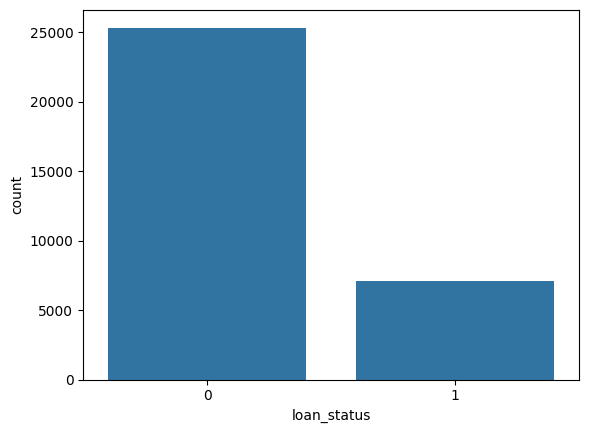

In [9]:
# Check imbalance
class_distribution = df['loan_status'].value_counts(normalize=True) * 100
print(class_distribution)

# Optional: Visualize
import seaborn as sns
sns.countplot(x='loan_status', data=df)

In [10]:
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']

In [12]:
from imblearn.over_sampling import (
    SMOTE,
    BorderlineSMOTE,
    SVMSMOTE,
    ADASYN,
    SMOTENC,
    KMeansSMOTE
)
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import pandas as pd

In [13]:
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

for col in X.columns:
  if X[col].dtype == 'Int64':
    X[col] = X[col].astype('float64')

smote = SMOTE()
X, y = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y))

After SMOTE: Counter({1: 25327, 0: 25327})


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
#scaling variables
svm_smote = SVMSMOTE()
X, y = svm_smote.fit_resample(X, y)
print("After SVMSMOTE:", Counter(y))

After SVMSMOTE: Counter({1: 25327, 0: 25327})


In [17]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the LightGBM classifier
lgbm_model = LGBMClassifier(random_state=42)

# Train the LightGBM model using the balanced training data
lgbm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgbm = lgbm_model.predict(X_test)

# Calculate evaluation metrics for the LightGBM model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

# Print the evaluation metrics for the LightGBM model
print("LightGBM Model Evaluation:")
print(f"Accuracy: {accuracy_lgbm:.4f}")
print(f"Precision: {precision_lgbm:.4f}")
print(f"Recall: {recall_lgbm:.4f}")
print(f"F1-score: {f1_lgbm:.4f}")

[LightGBM] [Info] Number of positive: 20262, number of negative: 20261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 40523, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500012 -> initscore=0.000049
[LightGBM] [Info] Start training from score 0.000049
LightGBM Model Evaluation:
Accuracy: 0.9550
Precision: 0.9900
Recall: 0.9192
F1-score: 0.9533


In [19]:
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# Instantiate and train the LightGBM classifier (already done in cell G9vtQIrY9TGW, reusing the trained model)
# lgbm_model = LGBMClassifier(random_state=42)
# lgbm_model.fit(X_train, y_train)

# Instantiate and train the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Create an ensemble using VotingClassifier
# 'soft' voting averages the probabilities
ensemble_model = VotingClassifier(estimators=[('lgbm', lgbm_model), ('xgb', xgb_model)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall: {recall_ensemble:.4f}")
print(f"F1-score: {f1_ensemble:.4f}")

[LightGBM] [Info] Number of positive: 20262, number of negative: 20261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 40523, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500012 -> initscore=0.000049
[LightGBM] [Info] Start training from score 0.000049

Ensemble Model Evaluation:
Accuracy: 0.9581
Precision: 0.9903
Recall: 0.9254
F1-score: 0.9567


In [20]:
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
}

print("LightGBM Parameter Grid:")
print(lgbm_param_grid)
print("\nXGBoost Parameter Grid:")
print(xgb_param_grid)

LightGBM Parameter Grid:
{'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [31, 63, 127], 'max_depth': [-1, 10, 20], 'min_child_samples': [20, 50, 100]}

XGBoost Parameter Grid:
{'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5], 'gamma': [0, 0.1, 0.2]}


In [22]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import xgboost as xgb

# Instantiate GridSearchCV for LightGBM
grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=lgbm_param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit GridSearchCV for LightGBM
grid_search_lgbm.fit(X_train, y_train)

# Print best parameters for LightGBM
print("Best parameters for LightGBM:")
print(grid_search_lgbm.best_params_)

# Store the best LightGBM model
best_lgbm_model = grid_search_lgbm.best_estimator_

# Instantiate GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit GridSearchCV for XGBoost
grid_search_xgb.fit(X_train, y_train)

# Print best parameters for XGBoost
print("\nBest parameters for XGBoost:")
print(grid_search_xgb.best_params_)

# Store the best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_

[LightGBM] [Info] Number of positive: 20262, number of negative: 20261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 40523, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500012 -> initscore=0.000049
[LightGBM] [Info] Start training from score 0.000049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for LightGBM:
{'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 63}

Best parameters for XGBoost:
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300}


In [23]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble using VotingClassifier with the best models
# 'soft' voting averages the probabilities
ensemble_model = VotingClassifier(estimators=[('lgbm', best_lgbm_model), ('xgb', best_xgb_model)], voting='soft')

# Train the ensemble model using the training data
ensemble_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 20262, number of negative: 20261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 40523, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500012 -> initscore=0.000049
[LightGBM] [Info] Start training from score 0.000049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,estimators,"[('lgbm', ...), ('xgb', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,boosting_type,'gbdt'
,num_leaves,63
,max_depth,10
,learning_rate,0.1
,n_estimators,300


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions with the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("Ensemble Model Evaluation (with best hyperparameters):")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall: {recall_ensemble:.4f}")
print(f"F1-score: {f1_ensemble:.4f}")

Ensemble Model Evaluation (with best hyperparameters):
Accuracy: 0.9636
Precision: 0.9910
Recall: 0.9356
F1-score: 0.9625
